In [1]:
import torch
mps_device = torch.device("mps")

import os
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import KFold

import tensorflow as tf
from keras.utils import to_categorical

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppress TensorFlow warnings (1=INFO, 2=WARNING, 3=ERROR)

2025-04-13 15:11:43.186640: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found 6862 files belonging to 11 classes.
Using 5490 files for training.
Using 1372 files for validation.


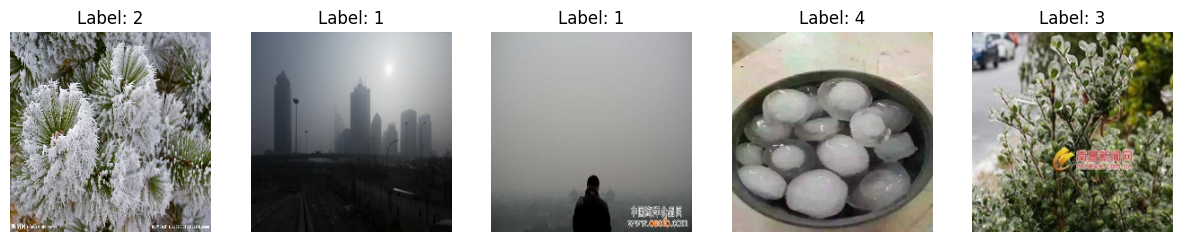

In [77]:
# Dataset/hyperparams
sandbox_dir = "../Data/Weather_Dataset"
batch_size = 32
image_size = (224, 224) #do not change for resnet50

# Load dataset
dataset = tf.keras.utils.image_dataset_from_directory(
    sandbox_dir,
    labels='inferred',
    label_mode='int',
    validation_split=0.2,
    subset="both",
    seed=1234,
    batch_size=batch_size,
    image_size=image_size,
    shuffle=True
)

### USE THESE 
train_dataset, test_dataset = dataset 
 
class_names = train_dataset.class_names

# print first 5 of training set
for images, labels in train_dataset.take(1):
    fig, axes = plt.subplots(1, 5, figsize=(15, 5))
    for i in range(5):
        axes[i].imshow(images[i].numpy().astype("uint8"))
        axes[i].axis("off")
        axes[i].set_title(f"Label: {labels[i].numpy()}")
    plt.show()
    break

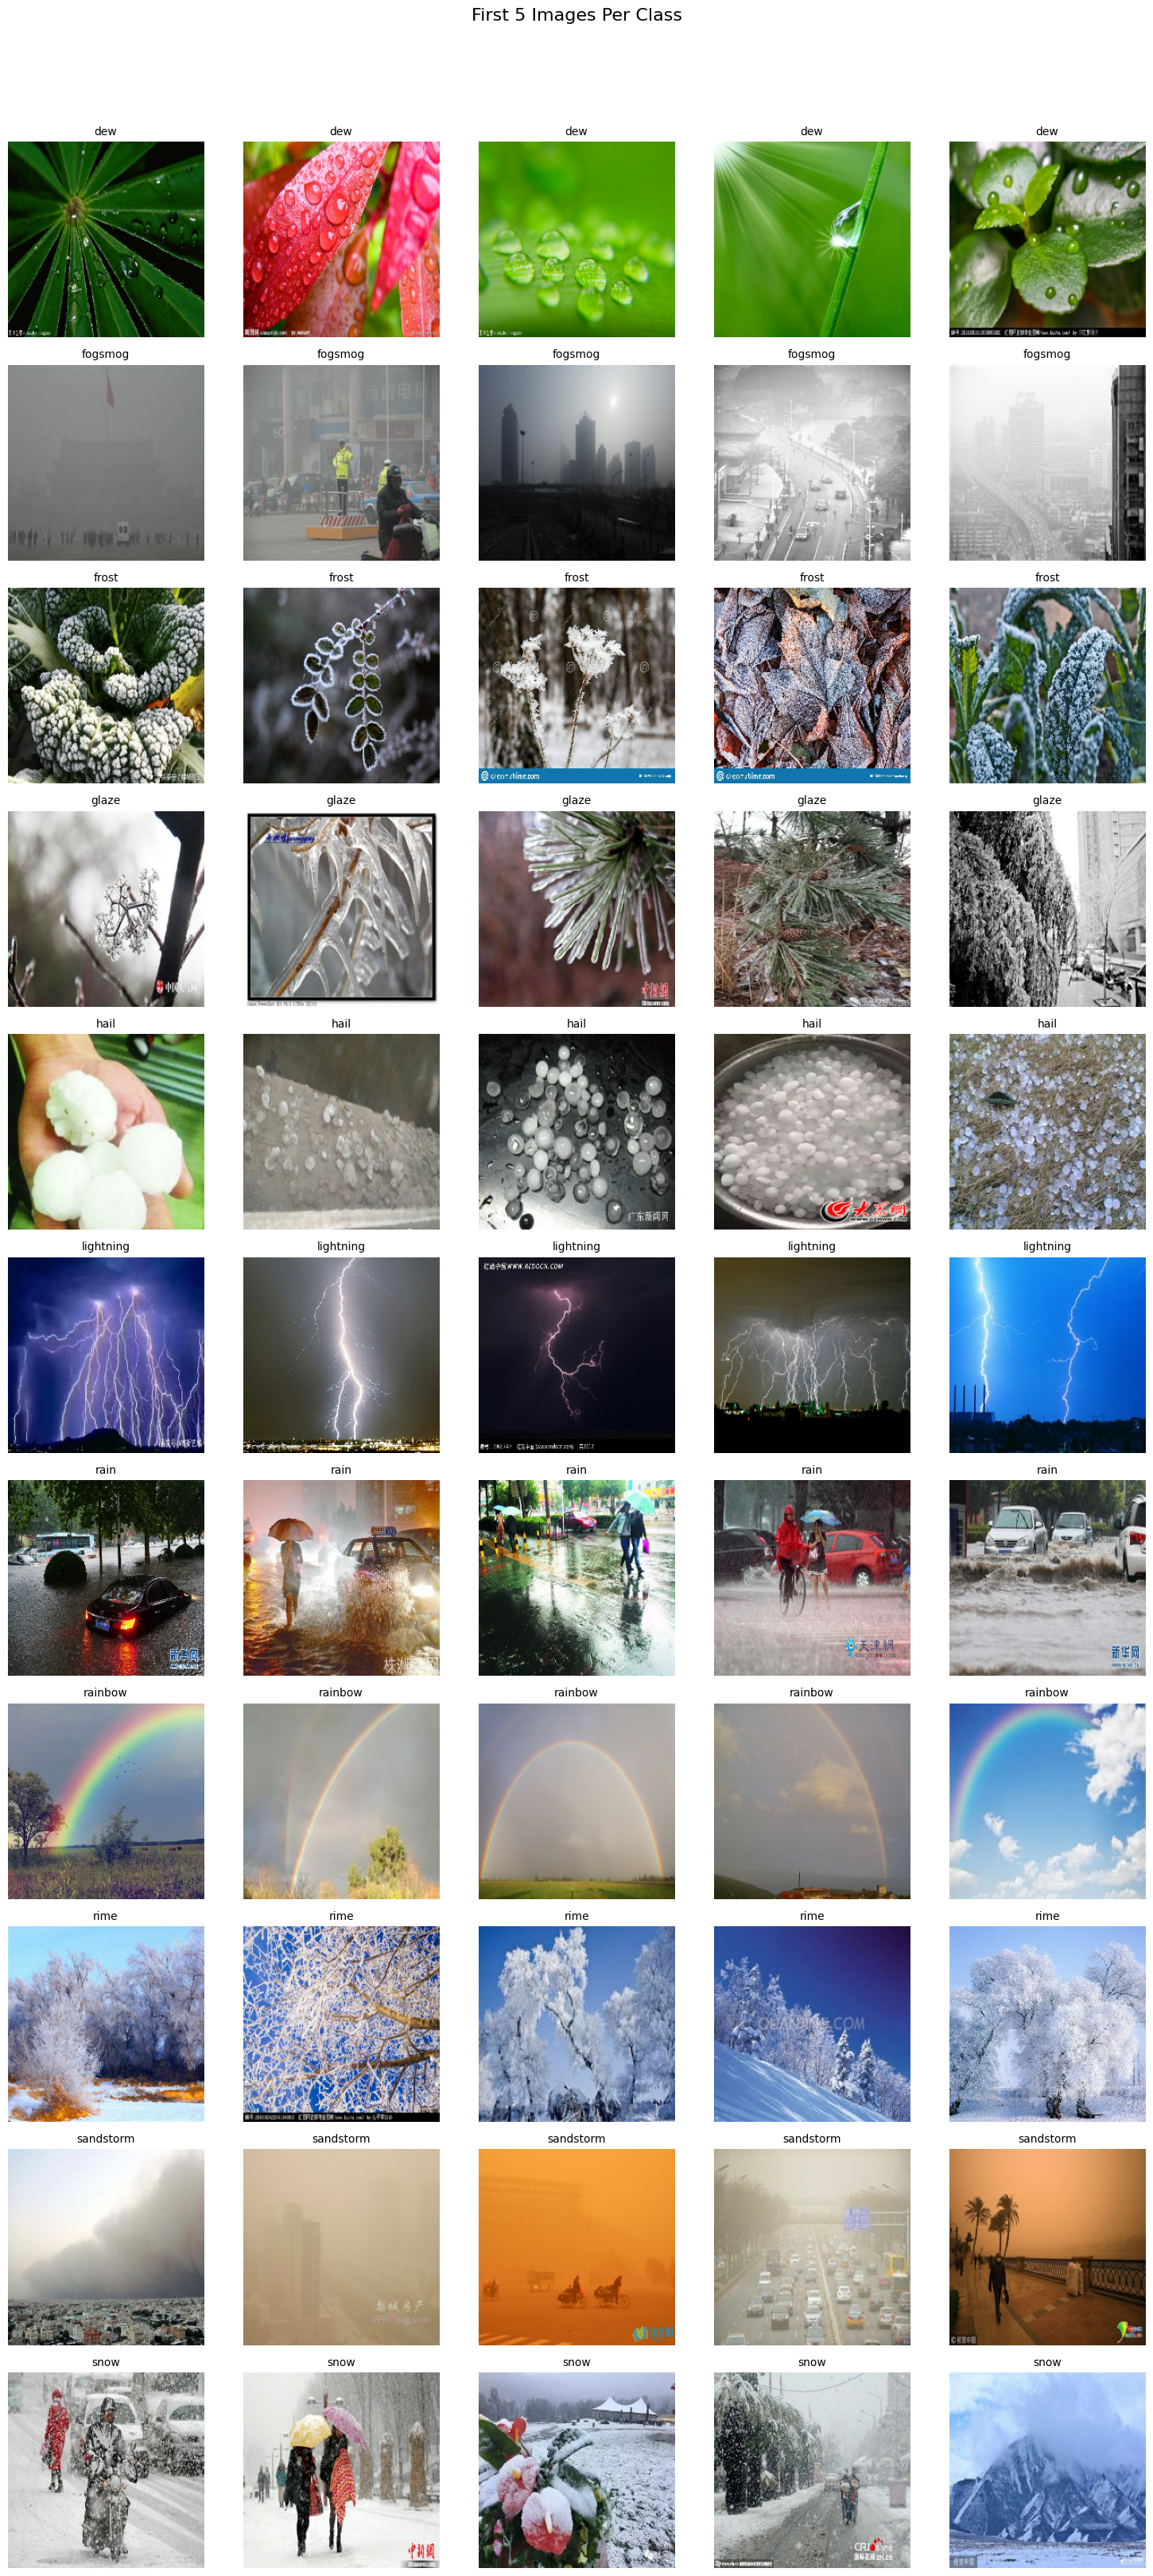

In [71]:
def display_first_images_per_class_in_one_plot(dataset, num_classes, class_names=None):
    # Unbatch the dataset to access individual samples
    unbatched_dataset = dataset.unbatch()

    # Create a dictionary to store the first 5 images per class
    images_per_class = {i: [] for i in range(num_classes)}

    # Iterate through the dataset and collect images for each class
    for image, label in unbatched_dataset:
        label = label.numpy()
        if len(images_per_class[label]) < 5:  # Collect up to 5 images per class
            images_per_class[label].append(image.numpy())
        if all(len(images) == 5 for images in images_per_class.values()):  # Stop if all classes have 5 images
            break

    # Create a single plot with rows for each class and 5 images per row
    fig, axes = plt.subplots(num_classes, 5, figsize=(15, num_classes * 3))
    fig.suptitle("First 5 Images Per Class", fontsize=16)

    for class_label, images in images_per_class.items():
        for i in range(5):
            ax = axes[class_label, i]
            ax.imshow(images[i].astype("uint8"))
            ax.axis("off")
            # Add a title to each image
            label_text = class_names[class_label] if class_names else f"Class {class_label}"
            ax.set_title(label_text, fontsize=10)

        # Add class label to the first column of each row
        row_label_text = class_names[class_label] if class_names else f"Class {class_label}"
        axes[class_label, 0].set_ylabel(row_label_text, fontsize=12, rotation=0, labelpad=50, ha='right', va='center')

    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit the title
    plt.show()

# Assuming train_dataset, num_classes, and class_names are already defined
# If class_names is not available, pass None
display_first_images_per_class_in_one_plot(train_dataset, 11, class_names=train_dataset.class_names)

In [79]:
# Convert the train dataset into two lists for images and labels
X_train, X_test, Y_train, Y_test = [], [], [], []

# Iterate through the batches
for images, labels in train_dataset:
    X_train.append(images)
    Y_train.append(labels)

# Iterate through the batches
for images, labels in test_dataset:
    X_test.append(images)
    Y_test.append(labels)

# Convert lists to TensorFlow tensors
X_train = tf.concat(X_train, axis=0).numpy()  # Combine batches into one tensor
Y_train = tf.concat(Y_train, axis=0).numpy()  # Combine labels into one tensor

# Split the data into training and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(
    X_train, Y_train, test_size=0.2, random_state=42  # 20% for validation
)

# Convert back to TensorFlow tensors if needed
X_train = tf.convert_to_tensor(X_train)
X_val = tf.convert_to_tensor(X_val)
Y_train = tf.convert_to_tensor(Y_train)
Y_val = tf.convert_to_tensor(Y_val)

print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)
print("X_val shape:", X_val.shape)
print("Y_val shape:", Y_val.shape)

2025-04-13 14:20:32.785865: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-04-13 14:20:33.723931: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-04-13 14:20:36.873639: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-04-13 14:20:38.735090: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-04-13 14:20:41.292524: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


X_train shape: (4392, 224, 224, 3)
Y_train shape: (4392,)
X_val shape: (1098, 224, 224, 3)
Y_val shape: (1098,)


Class Names: ['dew', 'fogsmog', 'frost', 'glaze', 'hail', 'lightning', 'rain', 'rainbow', 'rime', 'sandstorm', 'snow']


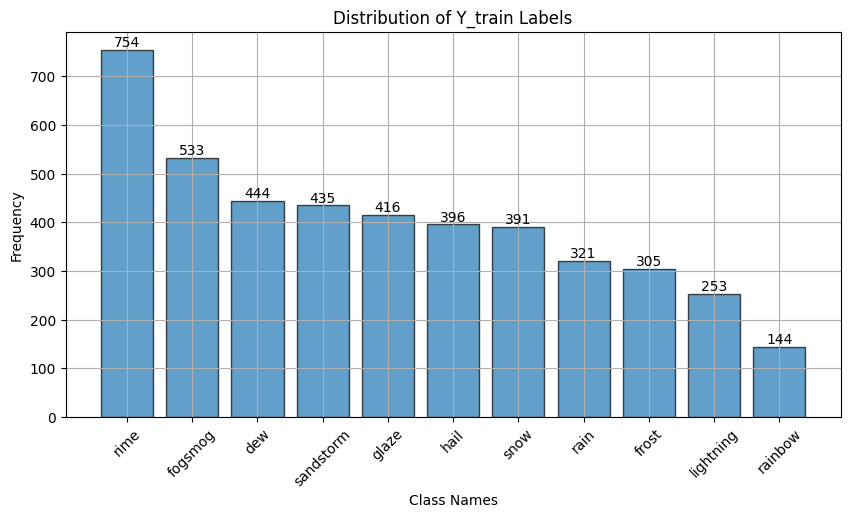

In [80]:
# Get class names from the dataset
class_names = train_dataset.class_names
print("Class Names:", class_names)

# Convert Tensor to NumPy array
Y_train_np = Y_train.numpy()

# Create a dictionary to map label indices to folder names
label_to_class = {i: class_names[i] for i in range(len(class_names))}

# Map labels to class names
Y_train_classes = [label_to_class[label] for label in Y_train_np]

# Count the frequency of each class
class_counts = {class_name: Y_train_classes.count(class_name) for class_name in class_names}

# Sort the class counts by frequency
sorted_class_counts = dict(sorted(class_counts.items(), key=lambda item: item[1], reverse=True))

# Plot the distribution with class names
plt.figure(figsize=(10, 5))
bars = plt.bar(sorted_class_counts.keys(), sorted_class_counts.values(), edgecolor='black', alpha=0.7)
plt.title("Distribution of Y_train Labels")
plt.xlabel("Class Names")
plt.ylabel("Frequency")
plt.grid(True)
plt.xticks(rotation=45)

# Label the frequencies on the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, int(yval), ha='center', va='bottom')

plt.show()

In [81]:
# Normalize the pixel values to [0, 1]
X_train = tf.cast(X_train, tf.float32) / 255.0
X_val = tf.cast(X_val, tf.float32) / 255.0

# Flatten the images using TensorFlow
X_train = tf.reshape(X_train, (tf.shape(X_train)[0], -1))
X_val = tf.reshape(X_val, (tf.shape(X_val)[0], -1))

# Print the shapes
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)


X_train shape: (4392, 150528)
X_val shape: (1098, 150528)


In [9]:
def build_model(num_features, learning_rate):
  """Build a TF logistic regression model using Keras.

  Args:
    num_features: The number of input features.
    learning_rate: The desired learning rate for SGD.

  Returns:
    model: A tf.keras model (graph).
  """
  # This is not strictly necessary, but each time you build a model, TF adds
  # new nodes (rather than overwriting), so the colab session can end up
  # storing lots of copies of the graph when you only care about the most
  # recent. Also, as there is some randomness built into training with SGD,
  # setting a random seed ensures that results are the same on each identical
  # training run.
  tf.keras.backend.clear_session()
  tf.random.set_seed(0)

  # Build a model using keras.Sequential. While this is intended for neural
  # networks (which may have multiple layers), we want just a single layer for
  # binary logistic regression.
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Dense(
      units=11,                     # output dim
      input_shape=[num_features],  # input dim
      use_bias=True,               # use a bias (intercept) param
      activation='softmax',     # softmax activation function for mutliclass classification
      kernel_initializer=tf.ones_initializer,  # initialize params to 1
      bias_initializer=tf.ones_initializer,    # initialize bias to 1
  ))

  # We need to choose an optimizer. We'll use SGD, which is actually mini-batch GD
  optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)

  # Finally, compile the model. Select the accuracy metric. This finalizes the graph for training.
  model.compile(optimizer=optimizer, loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['f1_score', 'auc', 'categorical_accuracy', 'precision', 'recall'])  # Categorical cross entropy (multiclass log loss)
  
  print(model.summary())

  return model

In [10]:
# Plot History and Evaluate Model
def plot_history(model_history):
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(model_history.history['categorical_accuracy'], label='Train Accuracy')
    plt.plot(model_history.history['val_categorical_accuracy'], label='Val Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Model Training Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(model_history.history['loss'], label='Train Loss')
    plt.plot(model_history.history['val_loss'], label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Model Training Loss')
    plt.show()
    
def evaluate_model(model, X_val, y_val):
    # Evaluate the model on the validation set
    val_metrics = model.evaluate(X_val, y_val, verbose=0)

    # Extract metrics in the correct order
    val_loss = val_metrics[0]
    val_f1 = np.mean(val_metrics[1])
    val_auc = val_metrics[2]
    val_accuracy = val_metrics[3]
    val_precision = val_metrics[4]
    val_recall = np.mean(val_metrics[5])

    # Print the metrics
    print(f"""Validation Loss: {val_loss}, Validation F1 Score: {val_f1}, Validation AUC: {val_auc}, 
    Validation Accuracy: {val_accuracy}, Validation Precision: {val_precision}, Validation Recall: {val_recall}""")
    
    # Get model predictions
    Y_val_pred = model.predict(x=X_val)
    # Get the class with the highest probability for each sample
    Y_val_pred_classes = np.argmax(Y_val_pred, axis=1)
    y_val_classes = np.argmax(y_val, axis=1)

    # Print classification report for subgroup accuracies
    print(classification_report(y_val_classes, Y_val_pred_classes, target_names=[str(label) for label in np.unique(y_val_classes)]))
    
    # Get confusion matrix
    conf_matrix=confusion_matrix(y_val_classes, Y_val_pred_classes)
    # Plot confusion matrix
    display = ConfusionMatrixDisplay(conf_matrix, display_labels=np.unique(y_val_classes))
    display.plot()
    plt.title("Validation Dataset Confusion Matrix")
    plt.yticks(fontsize=8)
    plt.xticks(fontsize=8, rotation=25)
    plt.show()

In [86]:
tf.random.set_seed(1234)

Y_train_encoded = to_categorical(np.array(Y_train))
Y_val_encoded = to_categorical(np.array(Y_val))

# Build the model
model= build_model(X_train.shape[1], learning_rate=0.0001)

model_history = model.fit(X_train, Y_train_encoded, validation_data=(X_val, Y_val_encoded), epochs=30, batch_size=32)

/Users/belladavies/.julia/conda/3/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 11)             │     1,655,819 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,655,819 (6.32 MB)

 Trainable params: 1,655,819 (6.32 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/30
138/138 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - auc: 0.6915 - categorical_accuracy: 0.2500 - f1_score: 0.1593 - loss: 2.1697 - precision: 0.6661 - recall: 0.0076 - val_auc: 0.7902 - val_categorical_accuracy: 0.3424 - val_f1_score: 0.1972 - val_loss: 1.8915 - val_precision: 0.7959 - val_recall: 0.1066
Epoch 2/30
138/138 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - auc: 0.8144 - categorical_accuracy: 0.4073 - f1_score: 0.2870 - loss: 1.8365 - precision: 0.8101 - recall: 0.0801 - val_auc: 0.8206 - val_categorical_accuracy: 0.4062 - val_f1_score: 0.2792 - val_loss: 1.7673 - val_precision: 0.7824 - val_recall: 0.1703
Epoch 3/30
138/138 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - auc: 0.8383 - categorical_accuracy: 0.4431 - f1_score: 0.3364 - loss: 1.7262 - precision: 0.8021 - recall: 0.1451 - val_auc: 0.8333 - val_categorical_accuracy: 0.4454 - val_f1_score: 0.3370 - val_loss: 1.7104 - val_precision: 0.7763 - val_recall: 0.2086
Epoch 4/30
138/138 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - auc: 0.8501 -

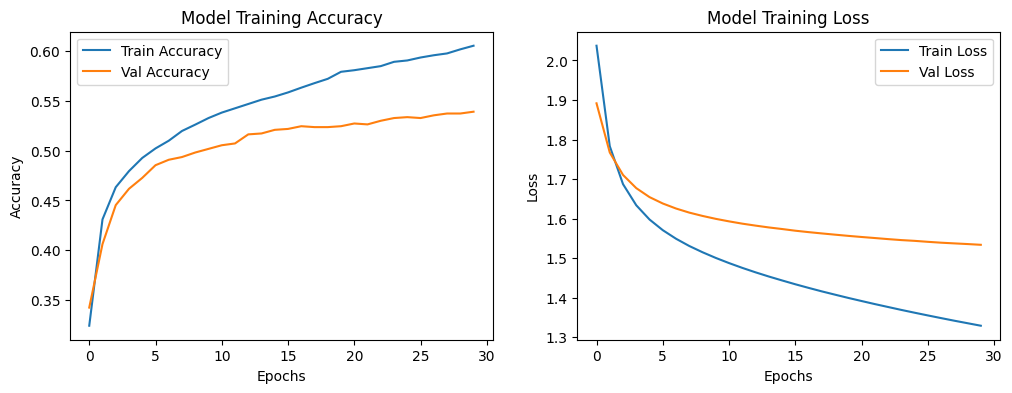

Validation Loss: 1.533900260925293, Validation F1 Score: 0.4671255350112915, Validation AUC: 0.8722731471061707, 
    Validation Accuracy: 0.5391620993614197, Validation Precision: 0.7782608866691589, Validation Recall: 0.3260473608970642
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
              precision    recall  f1-score   support

           0       0.85      0.65      0.74       115
           1       0.65      0.52      0.58       145
           2       0.50      0.01      0.03        74
           3       0.41      0.17      0.24        98
           4       0.42      0.66      0.51        89
           5       0.67      0.70      0.68        43
           6       0.58      0.28      0.38        76
           7       0.88      0.16      0.26        45
           8       0.47      0.89      0.62       178
           9       0.49      0.89      0.63       114
          10       0.61      0.39      0.47       121

    accuracy                           0.54      1098
   macro avg     

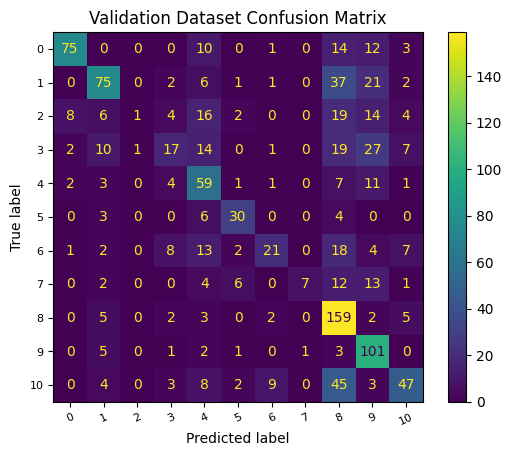

In [87]:
plot_history(model_history)
evaluate_model(model, X_val, Y_val_encoded)

# With 5-Fold Cross-Validation

In [88]:
# Convert TensorFlow tensors to NumPy arrays
X_train_np = X_train.numpy()
Y_train_np = Y_train.numpy()

# One-hot encode the labels
Y_train_encoded = to_categorical(Y_train_np)

# Define the number of folds
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Initialize variables to store average metrics
avg_val_loss, avg_val_f1, avg_val_auc, avg_val_acc, avg_val_prec, avg_val_rec = 0, 0, 0, 0, 0, 0
all_true_labels, all_pred_labels = [], []

# Perform k-fold cross-validation
fold_no = 1
for train_index, val_index in kf.split(X_train_np):
    print(f"Training fold {fold_no}...")
    
    # Split data into training and validation sets for this fold
    X_train_fold, X_val_fold = X_train_np[train_index], X_train_np[val_index]
    Y_train_fold, Y_val_fold = Y_train_encoded[train_index], Y_train_encoded[val_index]
    
    # Build and train the model
    model = build_model(X_train_fold.shape[1], learning_rate=0.0001)
    model.fit(X_train_fold, Y_train_fold, epochs=30, batch_size=32, validation_data=(X_val_fold, Y_val_fold))
    
    # Evaluate the model on the validation set
    val_metrics = model.evaluate(X_val_fold, Y_val_fold)
    print(f"Fold {fold_no} - Validation Metrics: {val_metrics}")
    
    val_loss, val_precision, val_recall, val_auc, val_accuracy = val_metrics[0], val_metrics[1], val_metrics[2], val_metrics[3], val_metrics[4]
    val_f1 = 2 * (val_precision * val_recall) / (val_precision + val_recall)
    
    print(f"Fold {fold_no} - Validation Loss: {val_loss}, Validation Precision: {val_precision}, Validation Recall: {val_recall}, Validation AUC: {val_auc}, Validation Accuracy: {val_accuracy}, Validation F1 Score: {val_f1}")
    
    # Predict the labels for the validation set
    Y_val_pred = model.predict(X_val_fold)
    Y_val_pred_classes = np.argmax(Y_val_pred, axis=1)
    Y_val_true_classes = np.argmax(Y_val_fold, axis=1)
    
    # Collect all true and predicted labels
    all_true_labels.extend(Y_val_true_classes)
    all_pred_labels.extend(Y_val_pred_classes)

    # Accumulate metrics
    avg_val_loss += val_loss
    avg_val_f1 += (2 * val_precision * val_recall) / (val_precision + val_recall)
    avg_val_auc += val_auc
    avg_val_acc += val_accuracy
    avg_val_prec += val_precision
    avg_val_rec += val_recall
    
    fold_no += 1

# Calculate the average validation metrics
avg_val_loss /= k
avg_val_auc /= k
avg_val_acc /= k
avg_val_rec /= k
avg_val_prec = np.mean(avg_val_prec)
avg_val_f1 = np.mean(avg_val_f1)

print(f"Average 5-Fold Cross Validation Loss: {avg_val_loss}")
print(f"Average 5-Fold Cross Validation F1 Score: {avg_val_f1}")
print(f"Average 5-Fold Cross Validation AUC: {avg_val_auc}")
print(f"Average 5-Fold Cross Validation Accuracy: {avg_val_acc}")
print(f"Average 5-Fold Cross Validation Precision: {avg_val_prec}")
print(f"Average 5-Fold Cross Validation Recall: {avg_val_rec}")

Training fold 1...


/Users/belladavies/.julia/conda/3/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 11)             │     1,655,819 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,655,819 (6.32 MB)

 Trainable params: 1,655,819 (6.32 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 10s 68ms/step - auc: 0.6886 - categorical_accuracy: 0.2380 - f1_score: 0.1487 - loss: 2.1816 - precision: 0.7288 - recall: 0.0073 - val_auc: 0.8071 - val_categorical_accuracy: 0.3834 - val_f1_score: 0.2256 - val_loss: 1.8900 - val_precision: 0.7027 - val_recall: 0.0296
Epoch 2/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - auc: 0.8116 - categorical_accuracy: 0.4029 - f1_score: 0.2770 - loss: 1.8521 - precision: 0.8205 - recall: 0.0686 - val_auc: 0.8389 - val_categorical_accuracy: 0.4141 - val_f1_score: 0.2755 - val_loss: 1.7622 - val_precision: 0.7710 - val_recall: 0.1149
Epoch 3/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - auc: 0.8380 - categorical_accuracy: 0.4538 - f1_score: 0.3430 - loss: 1.7305 - precision: 0.8260 - recall: 0.1419 - val_auc: 0.8505 - val_categorical_accuracy: 0.4323 - val_f1_score: 0.3039 - val_loss: 1.7001 - val_precision: 0.7374 - val_recall: 0.1502
Epoch 4/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - auc: 0.8507 

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 11)             │     1,655,819 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,655,819 (6.32 MB)

 Trainable params: 1,655,819 (6.32 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 14s 63ms/step - auc: 0.6854 - categorical_accuracy: 0.2368 - f1_score: 0.1501 - loss: 2.1849 - precision: 0.4640 - recall: 0.0046 - val_auc: 0.7834 - val_categorical_accuracy: 0.3720 - val_f1_score: 0.2475 - val_loss: 1.9559 - val_precision: 1.0000 - val_recall: 0.0228
Epoch 2/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - auc: 0.8171 - categorical_accuracy: 0.4026 - f1_score: 0.2806 - loss: 1.8489 - precision: 0.7572 - recall: 0.0579 - val_auc: 0.8134 - val_categorical_accuracy: 0.3959 - val_f1_score: 0.2854 - val_loss: 1.8245 - val_precision: 0.8557 - val_recall: 0.0944
Epoch 3/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - auc: 0.8441 - categorical_accuracy: 0.4521 - f1_score: 0.3430 - loss: 1.7233 - precision: 0.7859 - recall: 0.1155 - val_auc: 0.8267 - val_categorical_accuracy: 0.4323 - val_f1_score: 0.3430 - val_loss: 1.7604 - val_precision: 0.8000 - val_recall: 0.1274
Epoch 4/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - auc: 0.8565 

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 11)             │     1,655,819 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,655,819 (6.32 MB)

 Trainable params: 1,655,819 (6.32 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 12s 81ms/step - auc: 0.6866 - categorical_accuracy: 0.2174 - f1_score: 0.1516 - loss: 2.1937 - precision: 0.5444 - recall: 0.0082 - val_auc: 0.8002 - val_categorical_accuracy: 0.3633 - val_f1_score: 0.2224 - val_loss: 1.8764 - val_precision: 0.7059 - val_recall: 0.1230
Epoch 2/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - auc: 0.8032 - categorical_accuracy: 0.3947 - f1_score: 0.2857 - loss: 1.8815 - precision: 0.7282 - recall: 0.0558 - val_auc: 0.8352 - val_categorical_accuracy: 0.4339 - val_f1_score: 0.2998 - val_loss: 1.7175 - val_precision: 0.8085 - val_recall: 0.1731
Epoch 3/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - auc: 0.8304 - categorical_accuracy: 0.4362 - f1_score: 0.3385 - loss: 1.7618 - precision: 0.7739 - recall: 0.1197 - val_auc: 0.8505 - val_categorical_accuracy: 0.4624 - val_f1_score: 0.3346 - val_loss: 1.6396 - val_precision: 0.8326 - val_recall: 0.2039
Epoch 4/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - auc: 0.8436 

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 11)             │     1,655,819 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,655,819 (6.32 MB)

 Trainable params: 1,655,819 (6.32 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 11s 74ms/step - auc: 0.6990 - categorical_accuracy: 0.2344 - f1_score: 0.1496 - loss: 2.1703 - precision: 0.4232 - recall: 0.0102 - val_auc: 0.7816 - val_categorical_accuracy: 0.3827 - val_f1_score: 0.2581 - val_loss: 1.9377 - val_precision: 0.8571 - val_recall: 0.0410
Epoch 2/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - auc: 0.8169 - categorical_accuracy: 0.4172 - f1_score: 0.2881 - loss: 1.8407 - precision: 0.7852 - recall: 0.0704 - val_auc: 0.8167 - val_categorical_accuracy: 0.4214 - val_f1_score: 0.3184 - val_loss: 1.8007 - val_precision: 0.8137 - val_recall: 0.0945
Epoch 3/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - auc: 0.8431 - categorical_accuracy: 0.4485 - f1_score: 0.3296 - loss: 1.7189 - precision: 0.7616 - recall: 0.1330 - val_auc: 0.8319 - val_categorical_accuracy: 0.4476 - val_f1_score: 0.3549 - val_loss: 1.7322 - val_precision: 0.8000 - val_recall: 0.1458
Epoch 4/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - auc: 0.8559 

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 11)             │     1,655,819 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,655,819 (6.32 MB)

 Trainable params: 1,655,819 (6.32 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - auc: 0.6931 - categorical_accuracy: 0.2606 - f1_score: 0.1551 - loss: 2.1718 - precision: 0.6019 - recall: 0.0057 - val_auc: 0.7845 - val_categorical_accuracy: 0.3679 - val_f1_score: 0.2321 - val_loss: 1.9255 - val_precision: 0.8125 - val_recall: 0.0592
Epoch 2/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - auc: 0.8169 - categorical_accuracy: 0.4052 - f1_score: 0.2717 - loss: 1.8341 - precision: 0.8263 - recall: 0.0696 - val_auc: 0.8182 - val_categorical_accuracy: 0.4317 - val_f1_score: 0.3125 - val_loss: 1.7909 - val_precision: 0.7869 - val_recall: 0.1093
Epoch 3/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - auc: 0.8443 - categorical_accuracy: 0.4515 - f1_score: 0.3317 - loss: 1.7107 - precision: 0.8487 - recall: 0.1435 - val_auc: 0.8319 - val_categorical_accuracy: 0.4590 - val_f1_score: 0.3550 - val_loss: 1.7257 - val_precision: 0.8036 - val_recall: 0.1538
Epoch 4/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - auc: 0.8577 -

In [89]:

print(f"Average 5-Fold Cross Validation Loss: {avg_val_loss}")
print(f"Average 5-Fold Cross Validation F1 Score: {np.mean(avg_val_f1)}")
print(f"Average 5-Fold Cross Validation AUC: {avg_val_auc}")
print(f"Average 5-Fold Cross Validation Accuracy: {avg_val_acc}")
print(f"Average 5-Fold Cross Validation Precision: {np.mean(avg_val_prec)}")
print(f"Average 5-Fold Cross Validation Recall: {avg_val_rec}")

Average 5-Fold Cross Validation Loss: 1.5293755769729613
Average 5-Fold Cross Validation F1 Score: 2.8385701179504395
Average 5-Fold Cross Validation AUC: 0.5266465425491333
Average 5-Fold Cross Validation Accuracy: 0.7625549554824829
Average 5-Fold Cross Validation Precision: 2.300241231918335
Average 5-Fold Cross Validation Recall: 0.8731685638427734


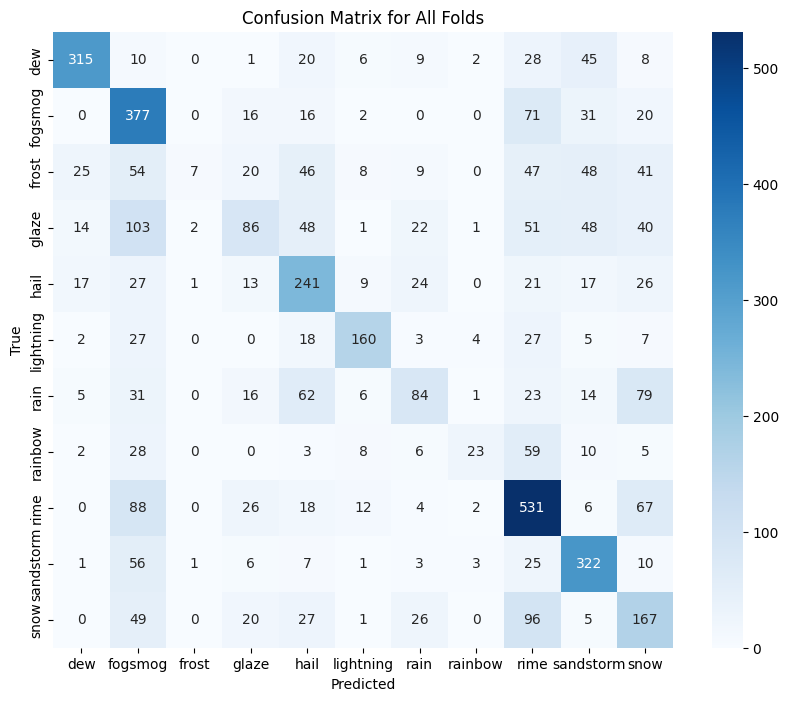

In [90]:
# Compute the confusion matrix for all folds
cm = confusion_matrix(all_true_labels, all_pred_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix for All Folds')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Logistic Regression with Balanced Oversampled Distribution

In [3]:
def load_data():
    # Dataset/hyperparams
    sandbox_dir = pathlib.Path("../Data/Weather_Dataset")
    batch_size = 8
    image_size = (224, 224)  # do not change for resnet50

    # Load dataset
    dataset = tf.keras.utils.image_dataset_from_directory(
        sandbox_dir,
        labels='inferred',
        label_mode='int',
        validation_split=0.2,
        subset="both",
        seed=1234,
        batch_size=batch_size,
        image_size=image_size,
        shuffle=True
    )

    ### USE THESE 
    train_dataset, test_dataset = dataset  

    # === Oversampling Preprocessing for the Training Dataset ===
    # Unbatch the training dataset to work with individual samples
    train_ds_unbatched = train_dataset.unbatch()

    # Retrieve class names and determine number of classes
    class_names = train_dataset.class_names
    num_classes = len(class_names)

    # Create a separate dataset for each class using filtering
    class_datasets = {}
    for i in range(num_classes):
        # Filter out samples that belong to class i
        class_datasets[i] = train_ds_unbatched.filter(lambda image, label: label == i)

    # Count samples per class
    counts = {}
    for i in range(num_classes):
        counts[i] = class_datasets[i].reduce(0, lambda x, _: x + 1).numpy()
    print("Original class counts:", counts)

    # Determine the maximum count among all classes
    max_count = max(counts.values())

    # Oversample each class: repeat and take exactly max_count samples for each
    oversampled_datasets = []
    for i in range(num_classes):
        ds = class_datasets[i].repeat().take(max_count)
        oversampled_datasets.append(ds)

    # Combine the oversampled datasets into one balanced dataset
    balanced_train_ds = oversampled_datasets[0]
    for ds in oversampled_datasets[1:]:
        balanced_train_ds = balanced_train_ds.concatenate(ds)

    # Shuffle and batch the balanced training dataset
    balanced_train_ds = balanced_train_ds.shuffle(buffer_size=1000).batch(batch_size)

    # Optionally, replace train_dataset with the balanced version
    train_dataset = balanced_train_ds

    # === Display a few samples from the balanced training dataset ===
    for images, labels in train_dataset.take(1):
        fig, axes = plt.subplots(1, 5, figsize=(15, 5))
        for i in range(5):
            axes[i].imshow(images[i].numpy().astype("uint8"))
            axes[i].axis("off")
            axes[i].set_title(f"Label: {labels[i].numpy()}")
        plt.show()
        break

    return train_dataset, test_dataset

In [4]:
def create_datasets(train_dataset, test_dataset):
    # Get X_val and y_val, normalize
    X_train, y_train = [], []
    for images, labels in train_dataset:
        X_train.append((images.numpy() / 255.0))
        y_train.append(labels.numpy())
    X_train = np.concatenate(X_train, axis=0)
    y_train = np.concatenate(y_train, axis=0)

    X_val, y_val = [], []
    for images, labels in test_dataset:
        X_val.append((images.numpy() / 255.0))
        y_val.append(labels.numpy())
    X_val = np.concatenate(X_val, axis=0)
    y_val = np.concatenate(y_val, axis=0)

    y_train = y_train.reshape(y_train.shape[0], 1)
    y_val = y_val.reshape(y_val.shape[0], 1)

    return X_train, y_train, X_val, y_val

Found 6862 files belonging to 11 classes.
Using 5490 files for training.
Using 1372 files for validation.
Original class counts: {0: 559, 1: 678, 2: 379, 3: 514, 4: 485, 5: 296, 6: 397, 7: 189, 8: 932, 9: 549, 10: 512}


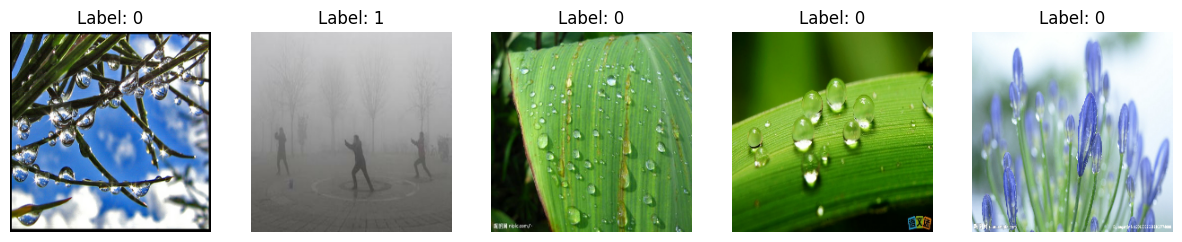

2025-04-13 15:14:47.308834: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-04-13 15:15:02.209801: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [5]:
# Load Data and Create Datasets
train_dataset_oversampled, test_dataset_oversampled = load_data()
X_train_oversampled, y_train_oversampled, X_test_oversampled, y_test_oversampled = create_datasets(train_dataset_oversampled, test_dataset_oversampled)

# Split training data into training and validation sets
X_train_oversampled, X_val_oversampled, y_train_oversampled, y_val_oversampled = train_test_split(
    X_train_oversampled, y_train_oversampled, test_size=0.2, random_state=42  # 20% of the data for validation
)

2025-04-13 15:17:19.107879: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


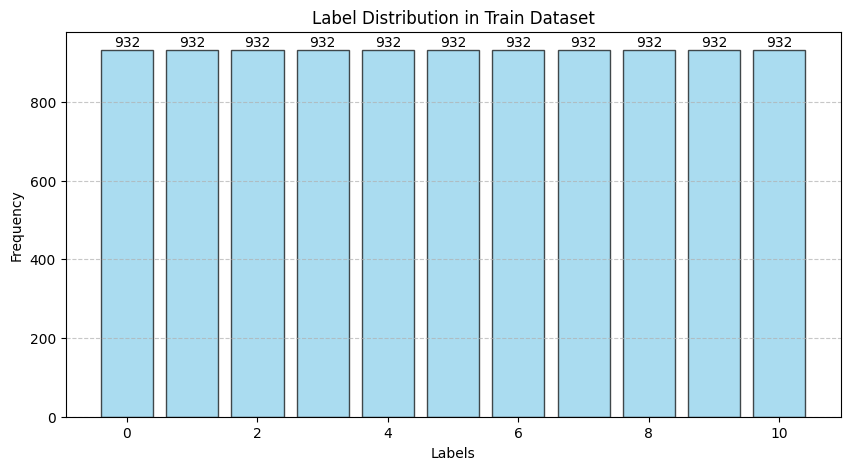

In [6]:
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np

def plot_label_distribution(dataset, num_classes):
    # Unbatch the dataset to access individual samples
    unbatched_dataset = dataset.unbatch()

    # Extract labels from the dataset
    labels = [label.numpy() for _, label in unbatched_dataset]

    # Count the occurrences of each label
    label_counts = Counter(labels)

    # Ensure all classes are represented in the counts
    label_counts = {i: label_counts.get(i, 0) for i in range(num_classes)}

    # Sort the labels for consistent ordering
    sorted_labels = sorted(label_counts.keys())
    sorted_counts = [label_counts[label] for label in sorted_labels]

    # Plot the distribution
    plt.figure(figsize=(10, 5))
    bars = plt.bar(sorted_labels, sorted_counts, color='skyblue', edgecolor='black', alpha=0.7)

    # Add labels to the bars
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.5, int(yval), ha='center', va='bottom')

    # Add titles and labels
    plt.title("Label Distribution in Train Dataset")
    plt.xlabel("Labels")
    plt.ylabel("Frequency")
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Show the plot
    plt.show()

# Assuming train_dataset and num_classes are already defined
plot_label_distribution(train_dataset_oversampled, 11)

In [7]:
# Flatten the images using TensorFlow
X_train_oversampled = tf.reshape(X_train_oversampled, (tf.shape(X_train_oversampled)[0], -1))
X_val_oversampled = tf.reshape(X_val_oversampled, (tf.shape(X_val_oversampled)[0], -1))


Y_train_encoded_oversampled = to_categorical(np.array(y_train_oversampled))
Y_val_encoded_oversampled = to_categorical(np.array(y_val_oversampled))

print(X_train_oversampled.shape)
print(y_train_oversampled.shape)
print(Y_train_encoded_oversampled.shape)
print(Y_val_encoded_oversampled.shape)

(8201, 150528)
(8201, 1)
(8201, 11)
(2051, 11)


In [11]:
tf.random.set_seed(1234)

model_oversampled = build_model(X_train_oversampled.shape[1], learning_rate=0.0001)

model_history_oversampled = model_oversampled.fit(X_train_oversampled, Y_train_encoded_oversampled, validation_split = 0.2, epochs=30)

/Users/belladavies/.julia/conda/3/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 11)             │     1,655,819 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,655,819 (6.32 MB)

 Trainable params: 1,655,819 (6.32 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/30
205/205 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - auc: 0.6753 - categorical_accuracy: 0.2195 - f1_score: 0.2082 - loss: 2.2154 - precision: 0.5135 - recall: 0.0037 - val_auc: 0.8295 - val_categorical_accuracy: 0.4449 - val_f1_score: 0.4306 - val_loss: 1.8478 - val_precision: 0.9524 - val_recall: 0.0366
Epoch 2/30
205/205 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - auc: 0.8233 - categorical_accuracy: 0.4095 - f1_score: 0.3862 - loss: 1.8373 - precision: 0.8691 - recall: 0.0593 - val_auc: 0.8485 - val_categorical_accuracy: 0.4778 - val_f1_score: 0.4658 - val_loss: 1.7158 - val_precision: 0.9192 - val_recall: 0.1109
Epoch 3/30
205/205 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - auc: 0.8439 - categorical_accuracy: 0.4391 - f1_score: 0.4183 - loss: 1.7237 - precision: 0.8367 - recall: 0.1176 - val_auc: 0.8567 - val_categorical_accuracy: 0.4912 - val_f1_score: 0.4803 - val_loss: 1.6567 - val_precision: 0.9043 - val_recall: 0.1554
Epoch 4/30
205/205 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - auc: 0.8542 -

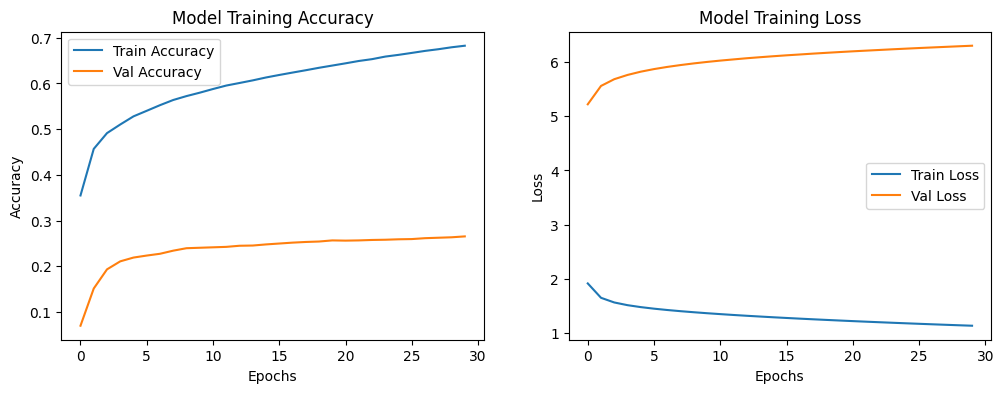

Validation Loss: 2.2985172271728516, Validation F1 Score: 0.44370585680007935, Validation AUC: 0.8241345286369324, 
    Validation Accuracy: 0.4883382022380829, Validation Precision: 0.7576923370361328, Validation Recall: 0.28717201948165894
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
              precision    recall  f1-score   support

           0       0.88      0.79      0.83       139
           1       0.52      0.62      0.56       173
           2       0.13      0.12      0.13        96
           3       0.48      0.36      0.41       125
           4       0.24      0.74      0.36       106
           5       0.52      0.79      0.63        81
           6       0.38      0.39      0.38       129
           7       0.32      0.28      0.30        43
           8       0.73      0.50      0.59       228
           9       0.88      0.55      0.68       143
          10       0.00      0.00      0.00       109

    accuracy                           0.49      1372
   macro avg  

/Users/belladavies/.julia/conda/3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/belladavies/.julia/conda/3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/belladavies/.julia/conda/3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

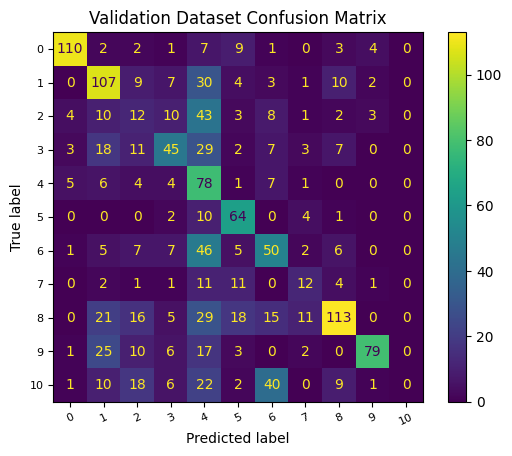

In [ ]:
plot_history(model_history_oversampled)
evaluate_model(model_oversampled, X_val_oversampled, Y_val_encoded_oversampled)